# Set up

In [24]:
library(IRdisplay)
library(FactoMineR)
library(tidyverse) #also plyr
library(ComplexHeatmap)
library(ggpubr)
library(NMF)

In [25]:
# Specify path to directory with downloaded data
data_dir_path = "aml"
stopifnot(file.exists(file.path(data_dir_path, 'exp')) & file.exists(file.path(data_dir_path, 'methy')) & 
          file.exists(file.path(data_dir_path, 'mirna')))

In [43]:
# Inrease plot resolution in this notebook
options(repr.plot.res=150)

In [76]:
# Load data
data_exp <- read.table(file.path(data_dir_path, 'exp'))
data_met <- read.table(file.path(data_dir_path, 'methy'))
data_mirna <- read.table(file.path(data_dir_path, 'mirna'))
subtypes <- read_tsv("TCGA_subtypes/AML_subtypes.tsv", show_col_types = FALSE)

In [102]:
# Basic pre-processing - remove non-informative features
c(dim(data_exp)[1], dim(data_met)[1], dim(data_mirna)[1])
exp.flt <- data_exp[!apply(data_exp, 1, sd) == 0,]
met.flt <- data_met[!apply(data_met, 1, sd) == 0,]
mirna.flt <- data_mirna[!apply(data_mirna, 1, sd) == 0,]
c(dim(exp.flt)[1], dim(met.flt)[1], dim(mirna.flt)[1])

[1] 20531  5000   705

[1] 19940  5000   561

## (1) Multi-omics data integration

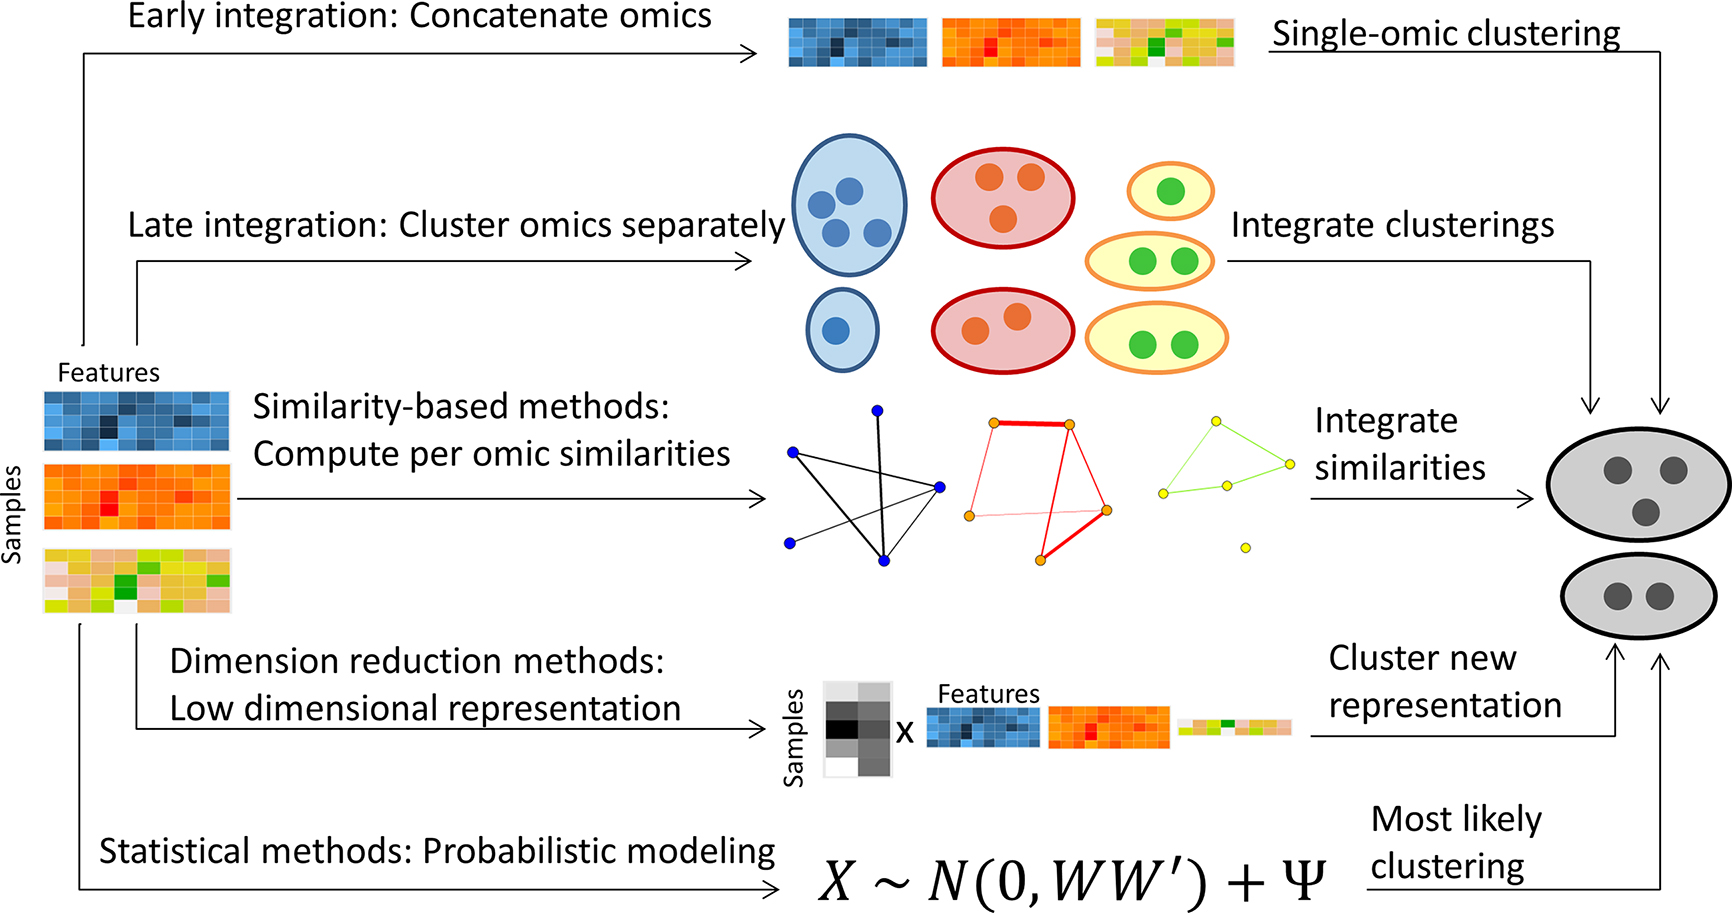

In [10]:
display_jpeg(file="img/gky889fig1.jpeg")

    Figure Source: Rappoport, N., & Shamir, R. (2018). Multi-omic and multi-view clustering algorithms: review and cancer benchmark. Nucleic Acids Research, 46(20), 10546–10562. https://doi.org/10.1093/nar/gky889

In [103]:
bound_matrices <- plyr::rbind.fill(exp.flt, met.flt, mirna.flt)
dim(bound_matrices)

[1] 25501   197

In [104]:
subtypes_data <- tibble(sample_codes=colnames(bound_matrices)) %>%  #in order of columns in bound_matrices
    left_join(subtypes, by = "sample_codes")  %>% 
    mutate(exp = sample_codes %in% colnames(exp.flt),
           met = sample_codes %in% colnames(met.flt),
           mirna = sample_codes %in% colnames(mirna.flt))
head(subtypes_data)

sample_codes,samples,Subtype_miRNA,Subtype_mRNA,Subtype_Selected,exp,met,mirna
<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
TCGA.AB.2803.03,TCGA-AB-2803,5,3,AML.3,TRUE,TRUE,TRUE
TCGA.AB.2805.03,TCGA-AB-2805,1,5,AML.5,TRUE,TRUE,TRUE
TCGA.AB.2806.03,TCGA-AB-2806,4,4,AML.4,TRUE,TRUE,TRUE
TCGA.AB.2807.03,TCGA-AB-2807,4,6,AML.6,TRUE,TRUE,TRUE
TCGA.AB.2808.03,TCGA-AB-2808,4,5,AML.5,TRUE,TRUE,TRUE
TCGA.AB.2810.03,TCGA-AB-2810,3,1,AML.1,TRUE,TRUE,TRUE


### Matrix Factorization Analysis (MFA)

In [105]:
# run the MFA function from the FactoMineR package (this may take a couple of minutes)
r.mfa <- MFA(
  t(bound_matrices), # binding the omics types together
  c(dim(exp.flt)[1], dim(met.flt)[1], dim(mirna.flt)[1]), # specifying the dimensions of each omic
  graph=FALSE)

In [106]:
# first, extract the H and W matrices from the MFA run result
mfa.h <- r.mfa$global.pca$ind$coord
mfa.w <- r.mfa$quanti.var$coord

# create a dataframe with the H matrix and the CMS label
mfa_df <- as.data.frame(mfa.h)
mfa_df$subtype_miRNA <- factor(subtypes_data$Subtype_miRNA)
mfa_df$subtype_mRNA <- factor(subtypes_data$Subtype_Selected)

mfa_df %>%
    as_tibble() %>% head()

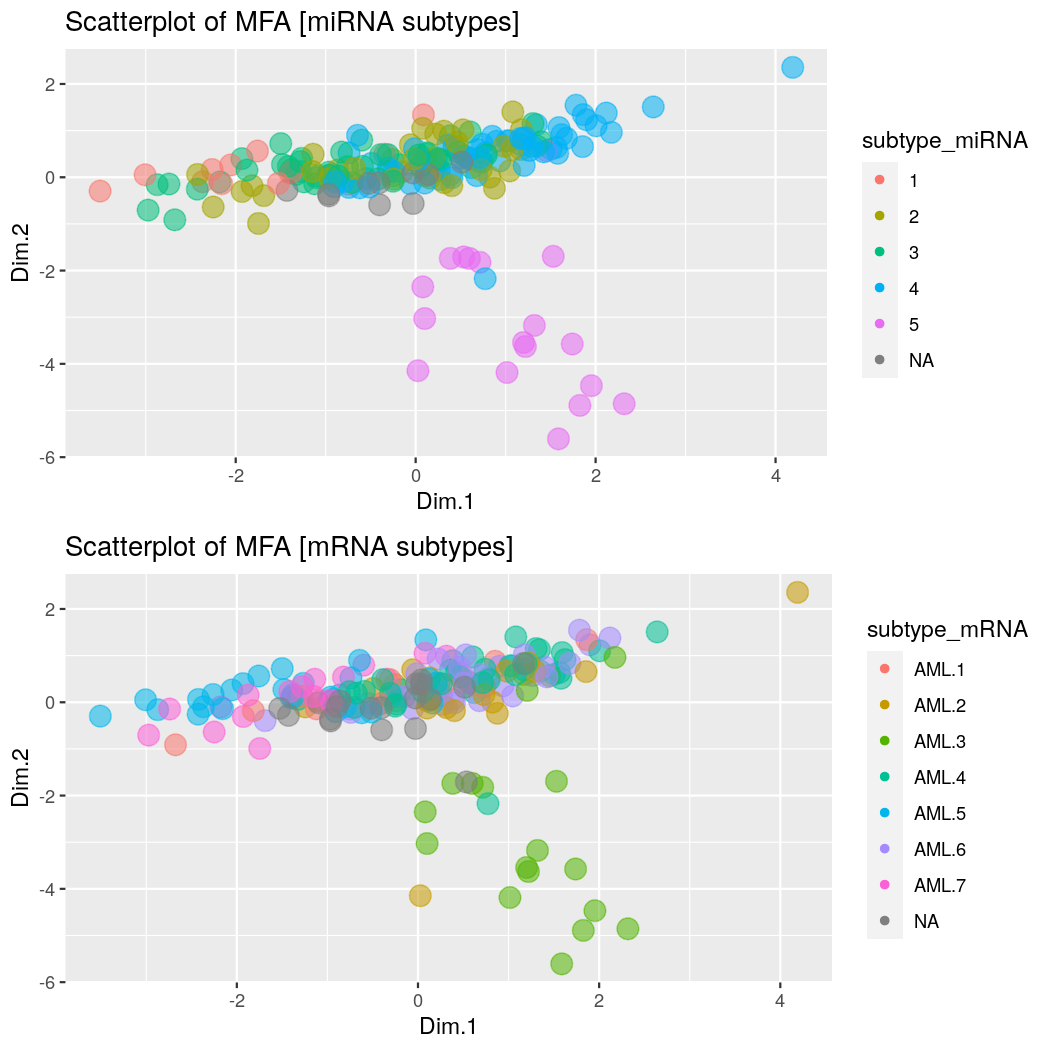

In [108]:
# inspect sample separation by existing subtypes
p1 <- mfa_df %>%
    as_tibble() %>%
    ggplot() + geom_point(aes(x=Dim.1, y=Dim.2, color=subtype_miRNA, size=1, alpha=0.5)) + 
    labs(title="Scatterplot of MFA [miRNA subtypes]") + guides(alpha=FALSE, size=FALSE)

p2 <- mfa_df %>%
    as_tibble() %>%
    ggplot() + geom_point(aes(x=Dim.1, y=Dim.2, color=subtype_mRNA, size=1, alpha=0.5)) + 
    labs(title="Scatterplot of MFA [mRNA subtypes]") + guides(alpha=FALSE, size=FALSE) 

ggarrange(p1, p2,ncol = 1) 

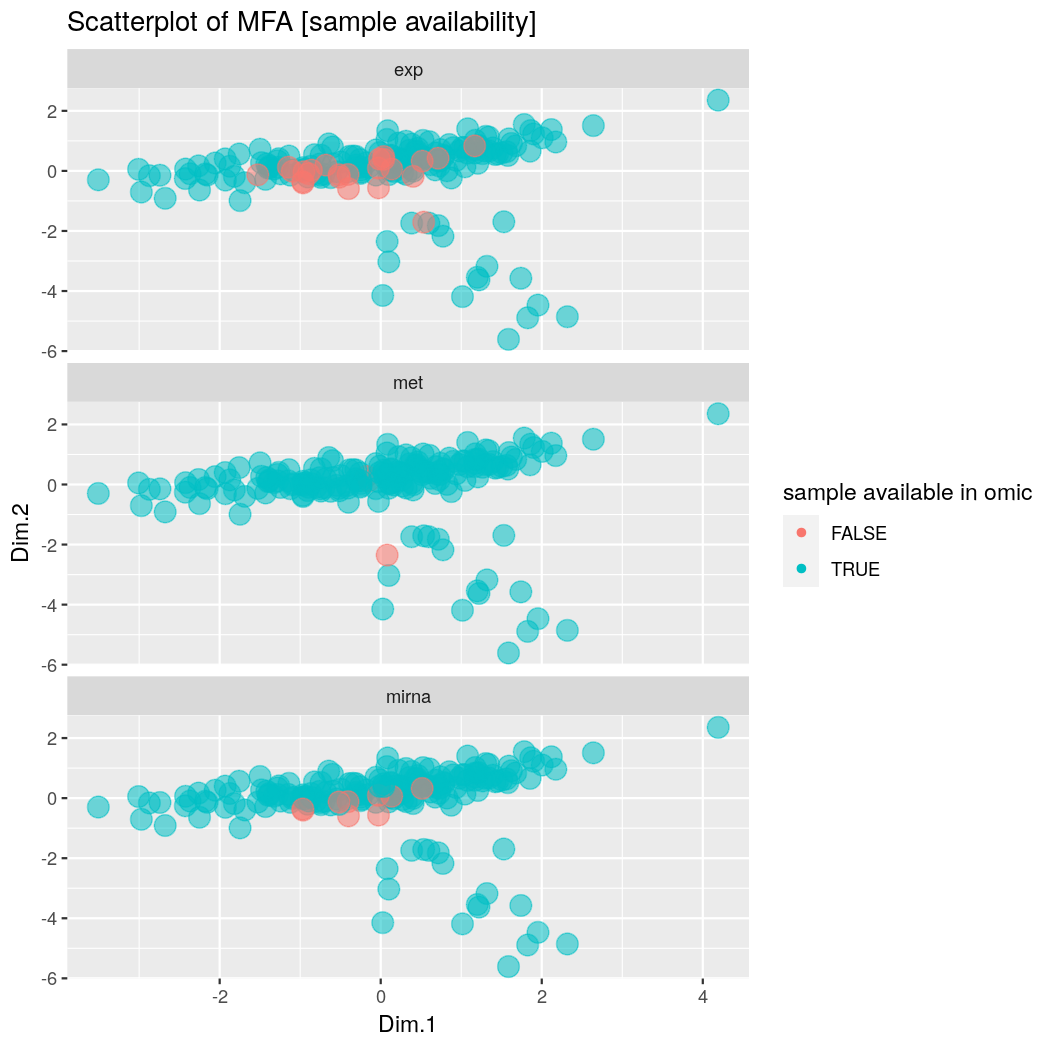

In [120]:
# let's check if our introduction of missing values (by matrix concatenation) do not drives sample separation
mfa_df %>% 
    as_tibble() %>%
    mutate(sample_codes=rownames(mfa_df)) %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    select(Dim.1, Dim.2, exp, met, mirna) %>%
    gather(omic, sample.available, -Dim.1, -Dim.2) %>%
    ggplot() + 
      geom_point(aes(x=Dim.1, y=Dim.2, color=sample.available, size=1, alpha=0.1)) + 
      facet_wrap(omic~., ncol=1) +
      labs(title="Scatterplot of MFA [sample availability]", color="sample available in omic") + 
      guides(alpha=FALSE, size=FALSE)

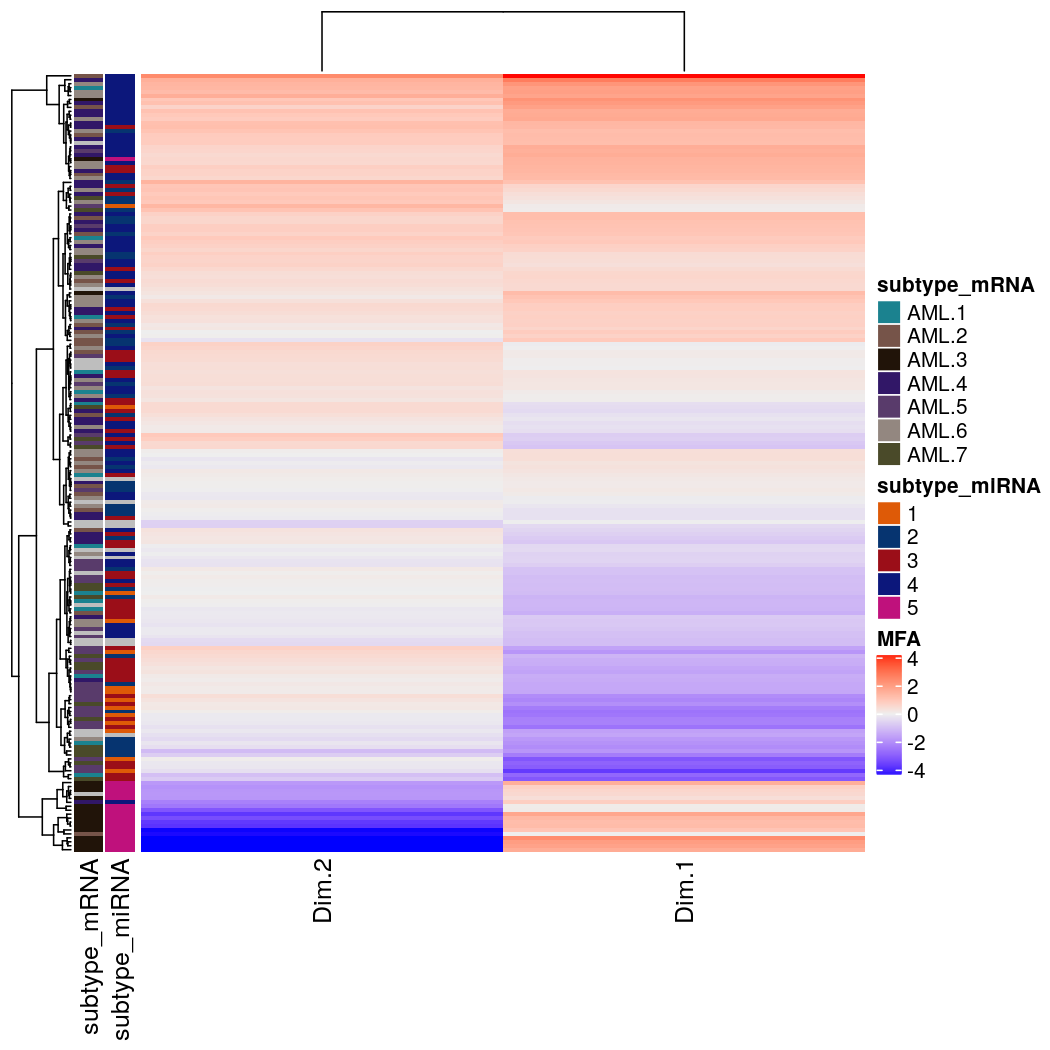

In [121]:
Heatmap(mfa.h[,1:2], show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, subtype_miRNA=mfa_df$subtype_miRNA))

###  Joint non-negative matrix factorization

In [129]:
eps <- .Machine$double.eps

In [130]:
# Feature-normalize the data
exp.featnorm <- (exp.flt + eps) / (rowSums(exp.flt) + eps)
met.featnorm <- (met.flt + eps) / (rowSums(met.flt) + eps)
mirna.featnorm <- (mirna.flt + eps) / (rowSums(mirna.flt) + eps)

# Normalize by each omics type's frobenius norm
exp.featnorm.frobnorm <- (exp.featnorm + eps) / (norm(as.matrix(exp.featnorm), type="F") + eps)
met.featnorm.frobnorm <- (met.featnorm + eps) / (norm(as.matrix(met.featnorm), type="F") + eps)
mirna.featnorm.frobnorm <- (mirna.featnorm + eps) / (norm(as.matrix(mirna.featnorm), type="F") + eps)

Note: We do not have any negative values, otherwise we would need to split the features of each matrix into two non-negative features each.

In [146]:
bound.featnorm.frobnorm <- plyr::rbind.fill(exp.featnorm.frobnorm, met.featnorm.frobnorm, mirna.featnorm.frobnorm)

In [155]:
library(doParallel)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators



In [ ]:
####################
# run the nmf function from the NMF package
print(detectCores())
cl <- makePSOCKcluster(detectCores() - 2) # register parallel backend doParallel package
registerDoParallel(cl)

r.nmf <- nmf(t(bound.featnorm.frobnorm), rank=2, method='Frobenius', .pbackend="mpi", .opt='v')

[1] 8


NMF algorithm: 'Frobenius'

NMF seeding method: random



Iterations:    1/2000

In [150]:
# run the nmf function from the NMF package
r.nmf <- nmf(t(bound.featnorm.frobnorm), rank=2, method='Frobenius')

# exctract the H and W matrices from the nmf run result
nmf.h <- NMF::basis(r.nmf)
nmf.w <- NMF::coef(r.nmf)
nmfw <- t(nmf.w)￼


Timing stopped at: 1794 0.867 1795



In [ ]:
# create a dataframe with the H matrix and the CMS label (subtype)
nmf_df <- as.data.frame(nmf.h)
colnames(nmf_df) <- c("dim1", "dim2")
nmf_df

In [149]:
nmf_df$subtype <- factor(covariates[rownames(nmf_df),]$cms_label)

nmf_df %>%
    as_tibble() %>% head()

ERROR: Error in as.data.frame(nmf.h): object 'nmf.h' not found


In [ ]:
# inspect sample separation by existing subtypes
p1 <- mfa_df %>%
    as_tibble() %>%
    ggplot() + geom_point(aes(x=Dim.1, y=Dim.2, color=subtype_miRNA, size=1, alpha=0.5)) + 
    labs(title="Scatterplot of MFA [miRNA subtypes]") + guides(alpha=FALSE, size=FALSE)

p2 <- mfa_df %>%
    as_tibble() %>%
    ggplot() + geom_point(aes(x=Dim.1, y=Dim.2, color=subtype_mRNA, size=1, alpha=0.5)) + 
    labs(title="Scatterplot of MFA [mRNA subtypes]") + guides(alpha=FALSE, size=FALSE) 

ggarrange(p1, p2,ncol = 1) 

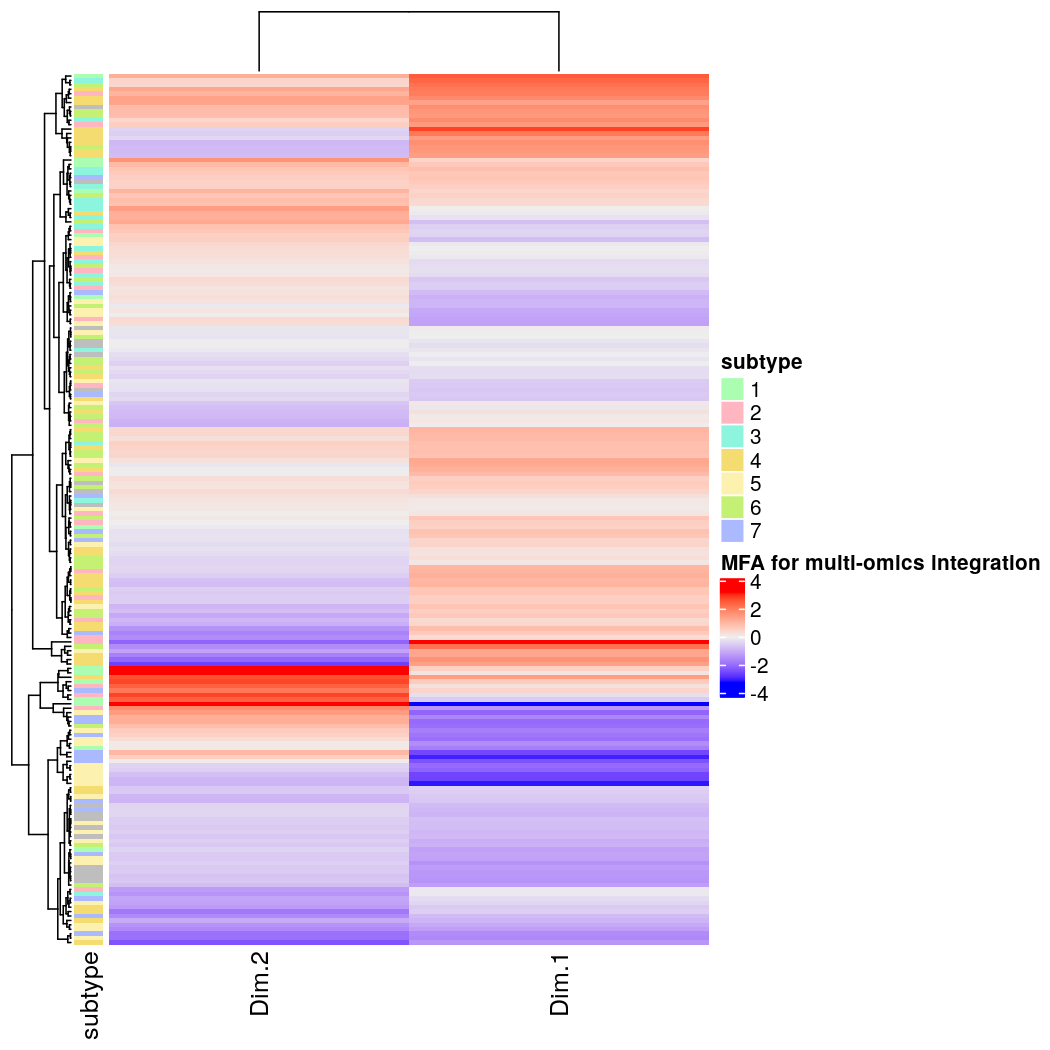

In [76]:
Heatmap(nmf_df[,1:2], left_annotation=rowAnnotation(subtype=mfa_df$subtype),
        show_row_names=FALSE, name="Heatmap of 2-component NMF")

### iCluster Plus

In [ ]:
# run the iClusterPlus function
r.icluster <- iClusterPlus::iClusterPlus(
  t(x1), # Providing each omics type
  t(x2),
  t(x3),
  type=c("gaussian", "binomial", "multinomial"), # Providing the distributions
  K=2, # provide the number of factors to learn
  alpha=c(1,1,1), # as well as other model parameters
  lambda=c(.03,.03,.03))

# extract the H and W matrices from the run result
# here, we refer to H as z, to keep with iCluster terminology
icluster.z <- r.icluster$meanZ
rownames(icluster.z) <- rownames(covariates) # fix the row names
icluster.ws <- r.icluster$beta

# construct a dataframe with the H matrix (z) and the cancer subtypes
# for later plotting
icp_df <- as.data.frame(icluster.z)
colnames(icp_df) <- c("dim1", "dim2")
rownames(icp_df) <- colnames(x1)
icp_df$subtype <- factor(covariates[rownames(icp_df),]$cms_label)

### PINS

In [ ]:
## Sample clustering using latent factors
# One-hot clusteing
# K-means clustering


In [ ]:
### SUMO

# consensus clustering

save expression -> data pre-processing
methylation M values to beta values ??

sumo prepare
sumo run k = 7
plot consensus matrix with labels

In [ ]:
### Interpretation of results 
# surivival + clinical analysis
# - feature weights of loading vectors
# gene enrichement analysis 